# Messung von Abständen zwischen Objekten
Dieses Notebook zeigt, wie man den Abstand von Objekten in einem Bild zum nächstgelegenen Objekt in einem anderen Bild messen kann. Ein Anwendungsfall dafür ist die Messung des Abstands von Objekten wie Zellen zu einem Gefäß. Das folgende Verfahren wird in 2D demonstriert und sollte analog in 3D funktionieren.

In [1]:
import numpy as np
import pyclesperanto_prototype as cle
import napari_simpleitk_image_processing as nsitk
import pandas as pd

Als Beispieldaten verwenden wir zwei synthetische Bilder: ein Binärbild, das zeigt, wo sich ein Gefäß als Streifen befindet, und ein Labelbild, das zeigt, wo sich Zellen / Objekte befinden.

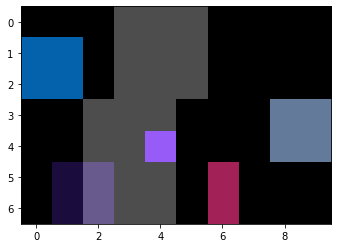

In [2]:
vessel = np.asarray([
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0, 0, 0, 0],
])

objects = np.asarray([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 5, 5],
    [0, 0, 0, 0, 2, 0, 0, 0, 5, 5],
    [0, 4, 4, 0, 0, 0, 3, 0, 0, 0],
    [0, 4, 4, 0, 0, 0, 3, 0, 0, 0],
])

cle.imshow(vessel, continue_drawing=True)
cle.imshow(objects, labels=True, alpha=0.7)

## Abstandskarten
Zur Messung des durchschnittlichen Abstands markierter Pixel zu einem anderen Objekt beinhaltet eine Strategie die Verwendung von [Abstandskarten](https://en.wikipedia.org/wiki/Distance_transform). Hier verwenden wir die in [SimpleITK](https://simpleitk.readthedocs.io/) implementierte [signierte Maurer-Abstandskarte](https://itk.org/ITKExamples/src/Filtering/DistanceMap/MaurerDistanceMapOfBinary/Documentation.html). Genauer gesagt verwenden wir das skriptfähige napari-Plugin [napari-simpleitk-image-processing](https://www.napari-hub.org/plugins/napari-simpleitk-image-processing), um auf diese Karte zuzugreifen. Wenn die Werte positiv sind, befinden wir uns außerhalb des Gefäßes. Negative Werte deuten darauf hin, dass wir uns im Inneren befinden.

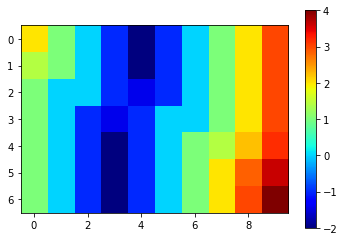

In [3]:
not_vessel = cle.binary_not(vessel)

distance_from_vessel = nsitk.signed_maurer_distance_map(not_vessel)

cle.imshow(distance_from_vessel, colorbar=True, colormap="jet")

## Objektabstandskarte
Als Nächstes messen wir die durchschnittliche Intensität in der Abstandskarte, wo sich die Objekte befinden. Diese Intensitäten repräsentieren den durchschnittlichen Abstand dieser Objekte zum Gefäß. Die Hintergrundintensität in diesen Karten (in unserem Fall der Abstand) ist definitionsgemäß 0.

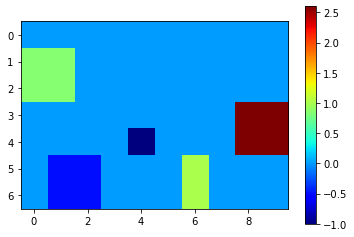

In [4]:
mean_distance_map = cle.mean_intensity_map(distance_from_vessel, objects)

cle.imshow(mean_distance_map, colorbar=True, colormap="jet")

Alternativ zu dieser Visualisierung können wir den durchschnittlichen Abstand auch mithilfe von Pixelstatistiken auslesen und mit einem [pandas Dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) ausgeben.

In [5]:
statistics = cle.statistics_of_labelled_pixels(distance_from_vessel, objects)

table = pd.DataFrame(statistics)
table = table[['label', 'mean_intensity']]
table = table.rename(columns={'mean_intensity':'mean_distance'})

table

label  mean_distance
0      1       0.853553
1      2      -1.000000
2      3       1.000000
3      4      -0.500000
4      5       2.599586

## Filtern von Objekten
Sie können auch Objekte nach ihrem Abstand zum Gefäß filtern.

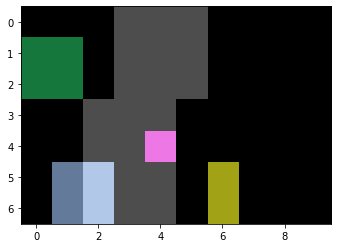

In [6]:
min_distance = -4
max_distance = 2
objects_close_by_vessel = cle.exclude_labels_with_map_values_out_of_range(
    mean_distance_map,
    objects,
    minimum_value_range=min_distance,
    maximum_value_range=max_distance
)

cle.imshow(vessel, continue_drawing=True)
cle.imshow(objects_close_by_vessel, labels=True, alpha=0.7)